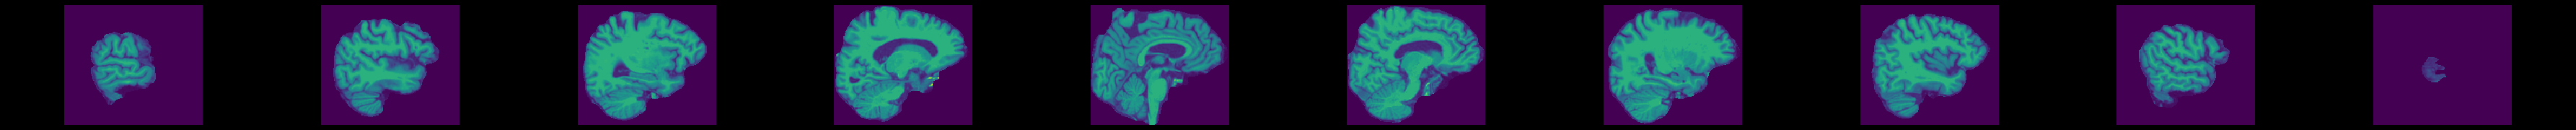

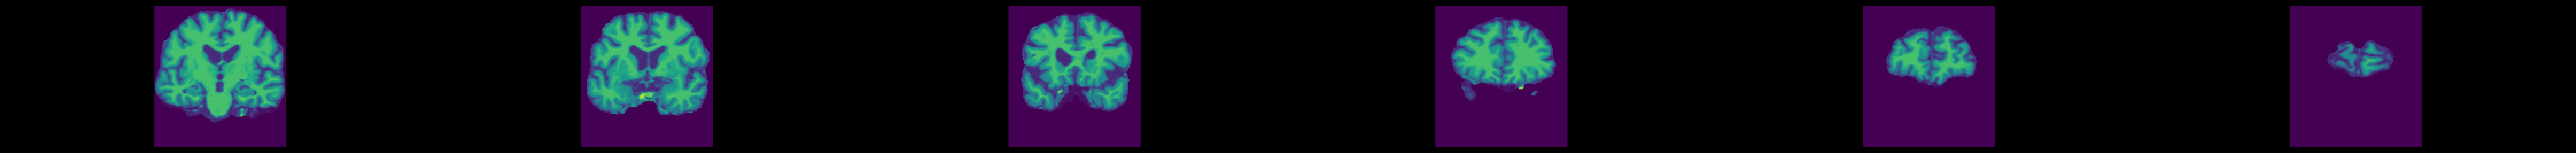

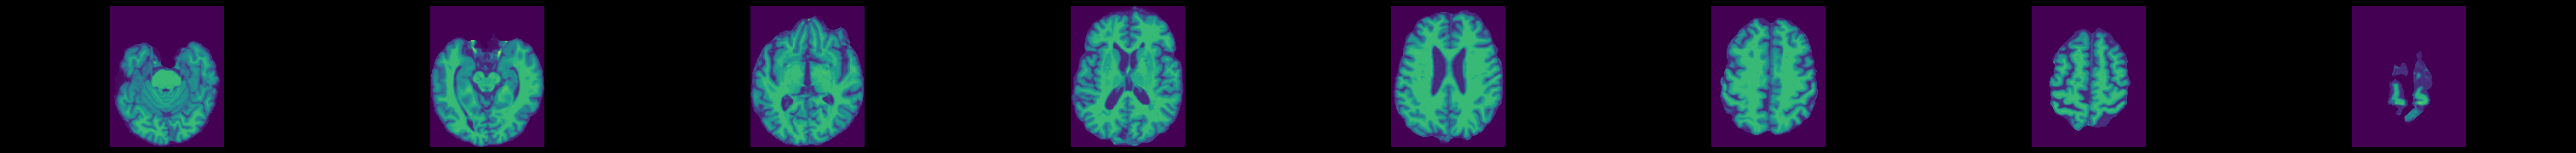

processed: ../../ADNI/002_S_0295/FreeSurfer_Cross-Sectional_Processing_brainmask/2006-04-18_08_20_30.0/S13408/mri/brainmask.mgz


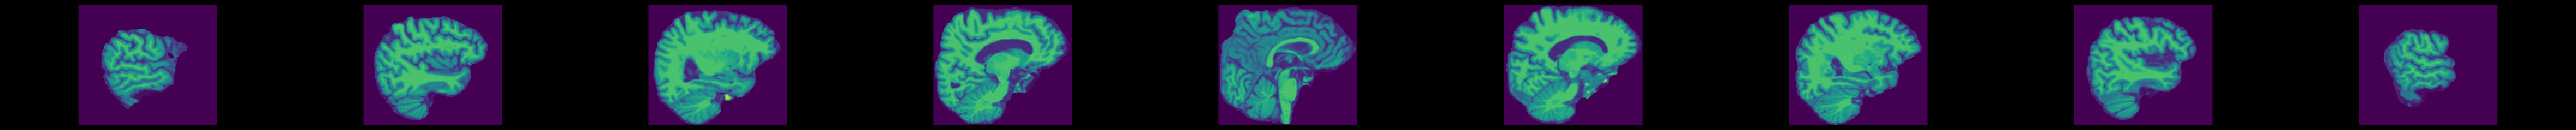

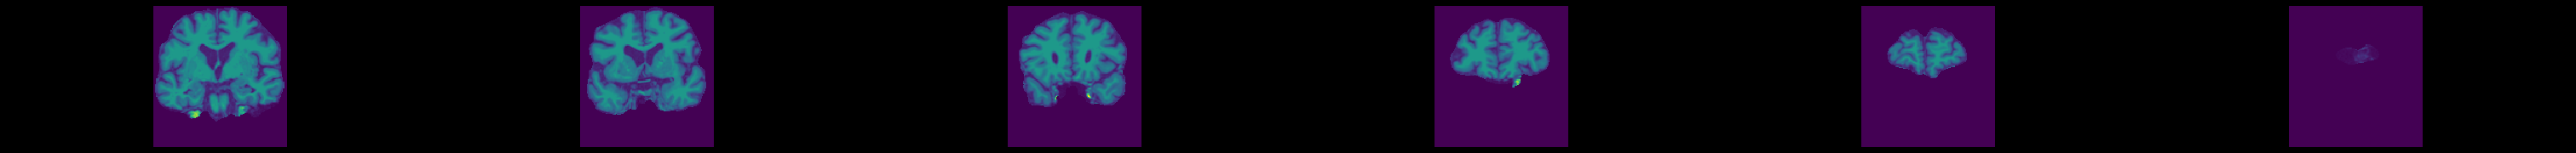

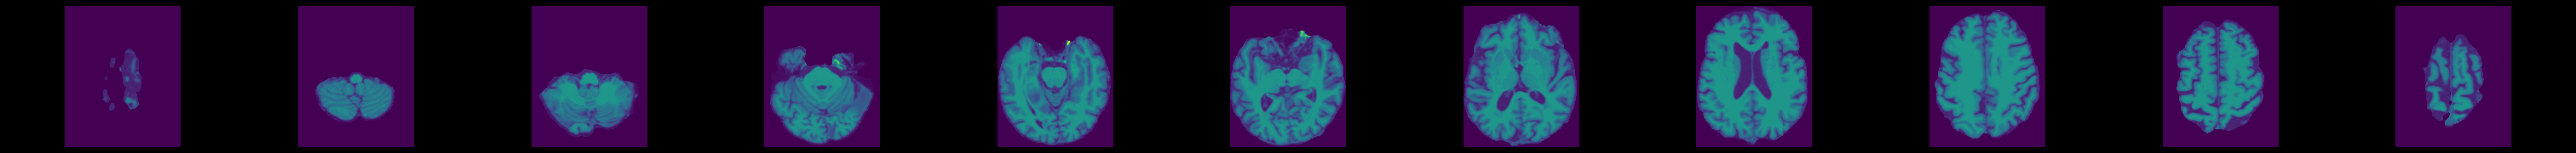

processed: ../../ADNI/002_S_0295/FreeSurfer_Cross-Sectional_Processing_brainmask/2006-11-02_08_16_44.0/S21856/mri/brainmask.mgz


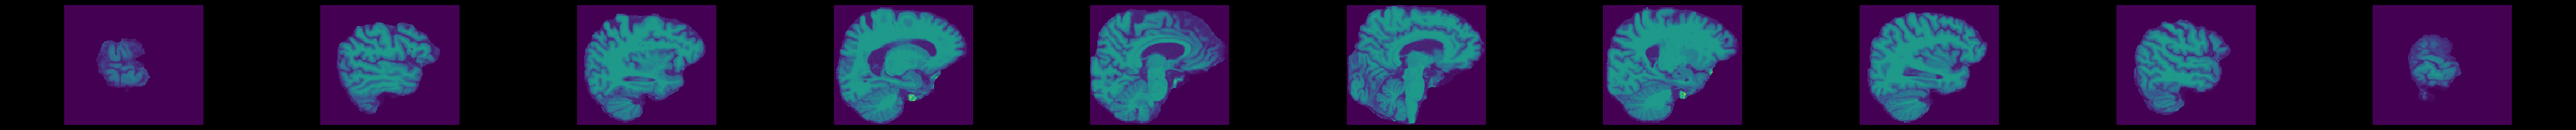

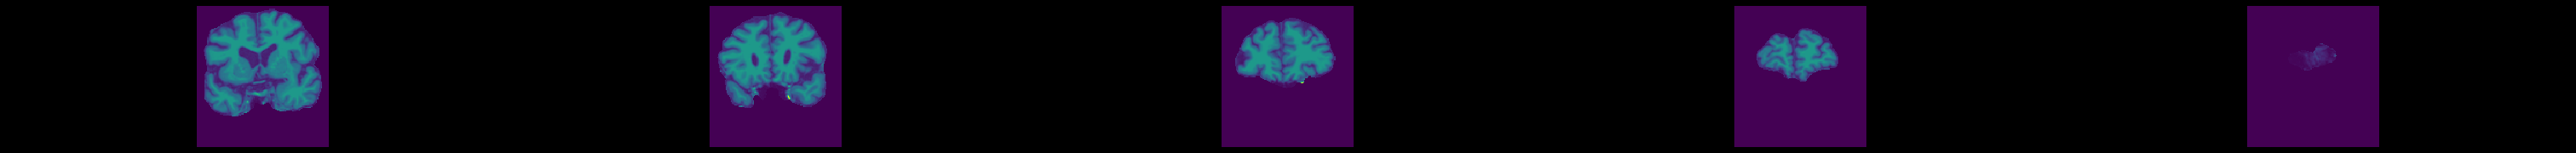

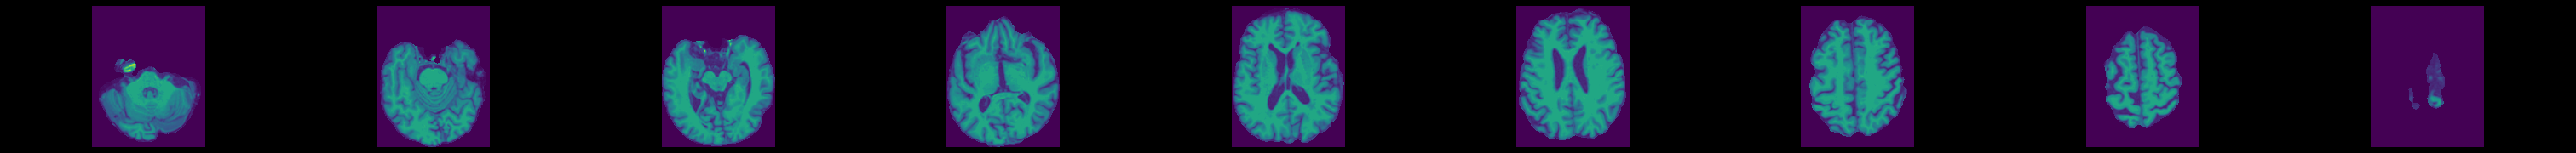

processed: ../../ADNI/002_S_0295/FreeSurfer_Cross-Sectional_Processing_brainmask/2007-05-25_07_12_36.0/S32678/mri/brainmask.mgz


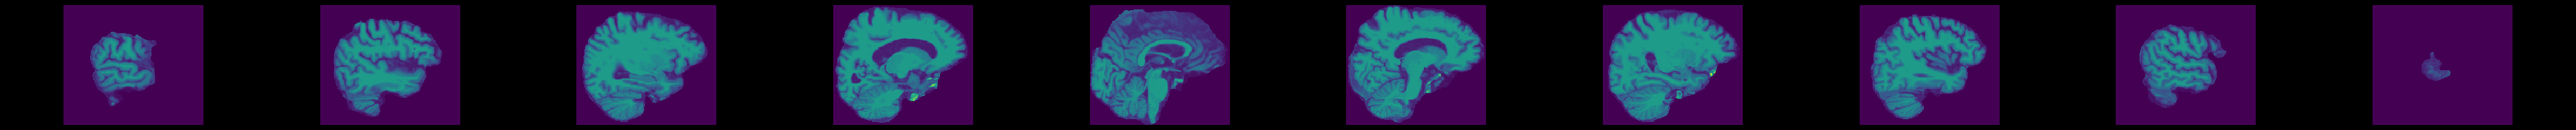

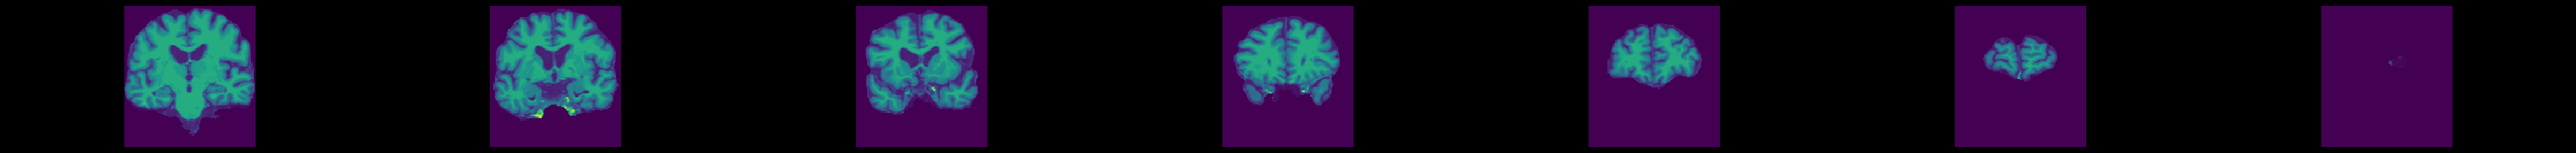

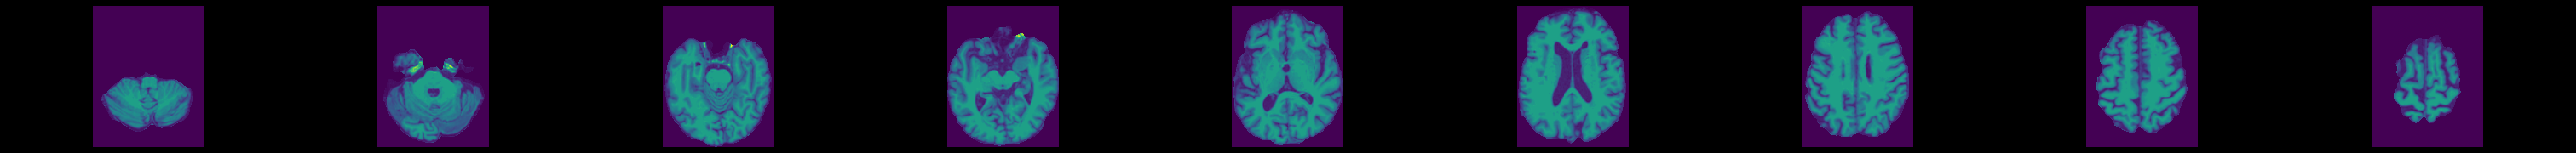

processed: ../../ADNI/002_S_0295/FreeSurfer_Cross-Sectional_Processing_brainmask/2008-07-23_14_51_41.0/S54061/mri/brainmask.mgz


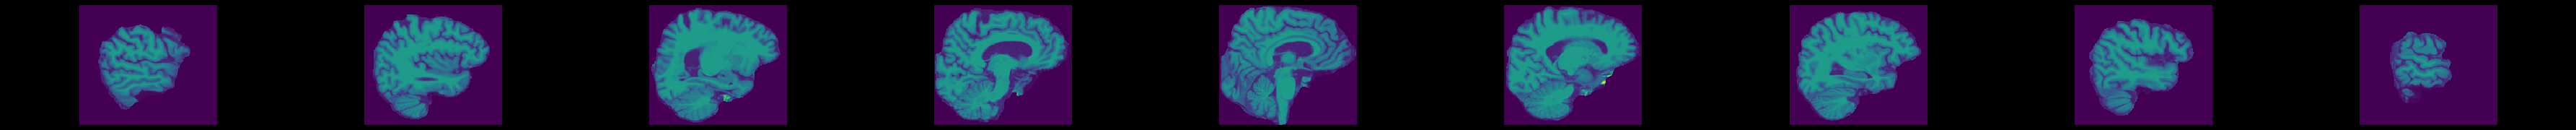

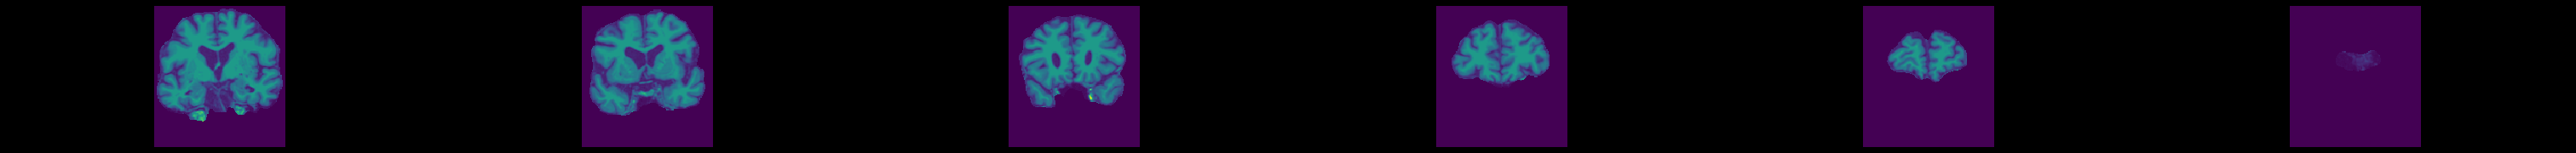

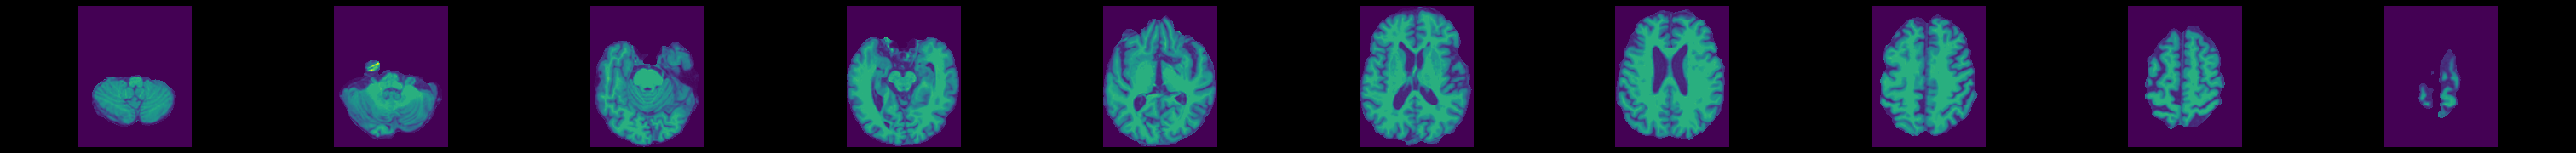

processed: ../../ADNI/002_S_0295/FreeSurfer_Cross-Sectional_Processing_brainmask/2009-05-22_07_00_57.0/S67612/mri/brainmask.mgz


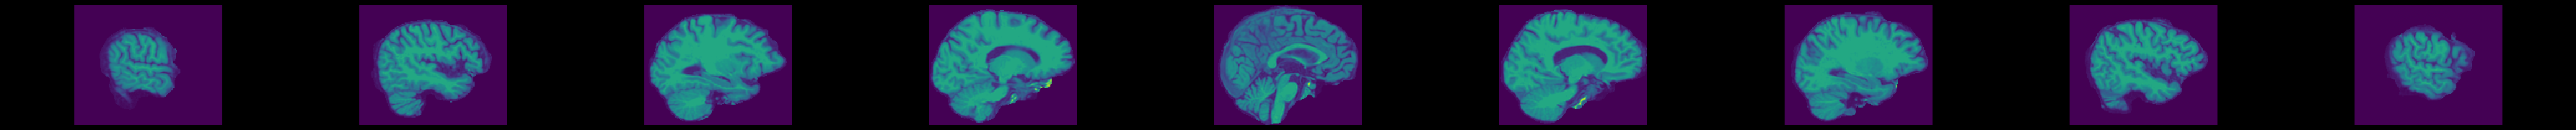

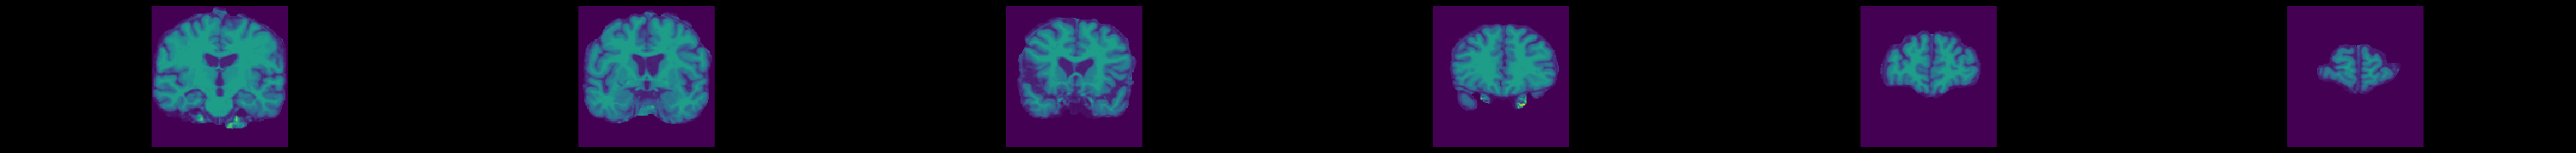

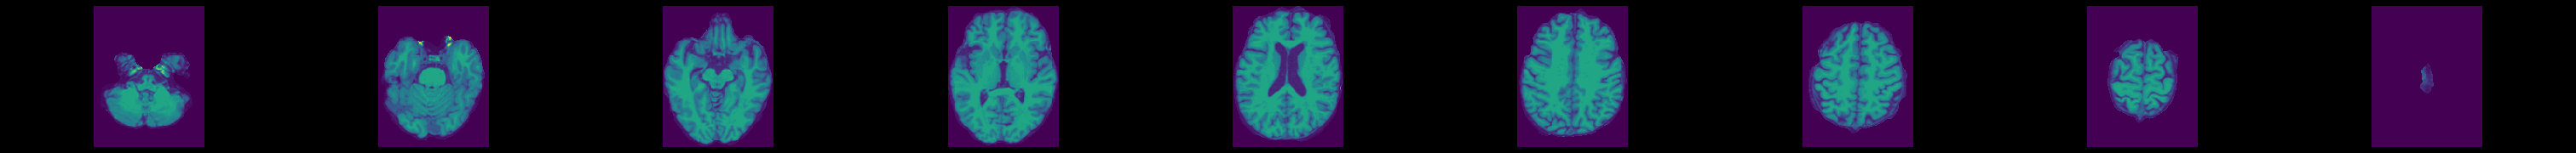

processed: ../../ADNI/002_S_0413/FreeSurfer_Cross-Sectional_Processing_brainmask/2006-05-02_12_31_52.0/S13893/mri/brainmask.mgz


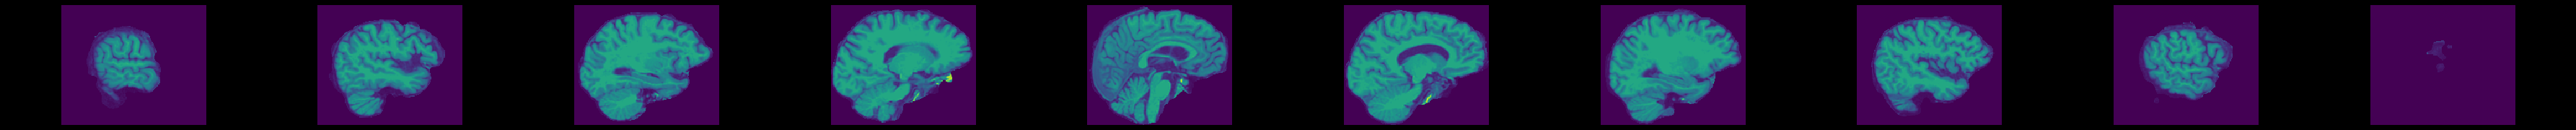

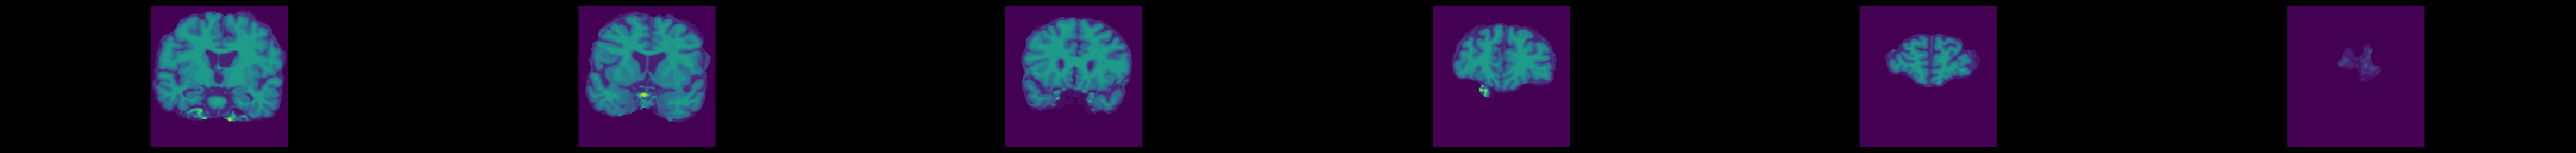

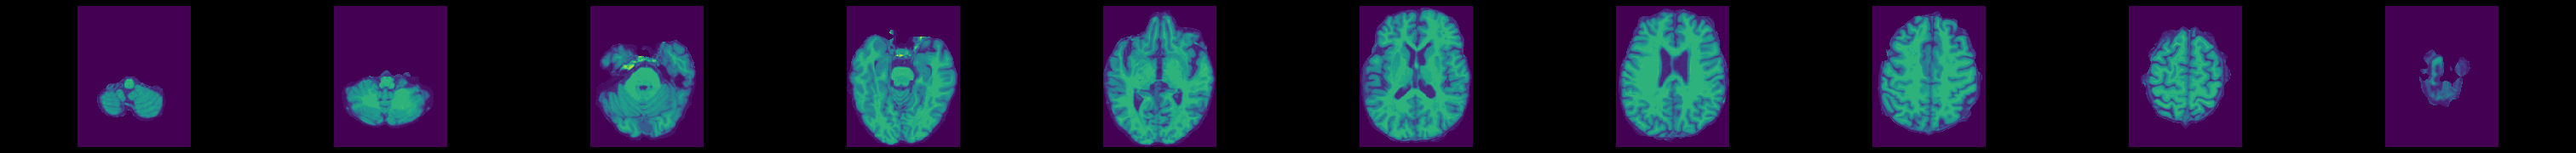

processed: ../../ADNI/002_S_0413/FreeSurfer_Cross-Sectional_Processing_brainmask/2006-11-15_09_30_01.0/S22557/mri/brainmask.mgz


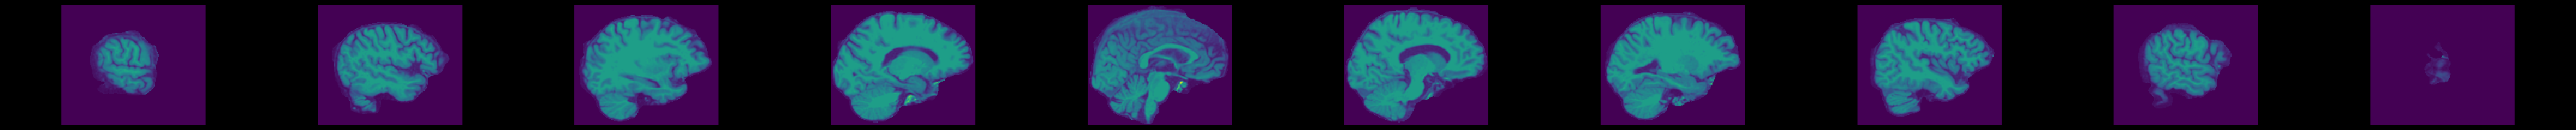

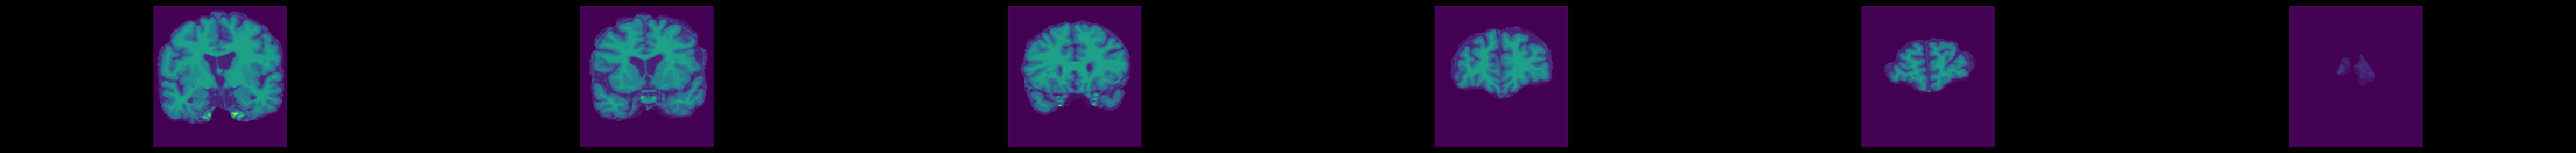

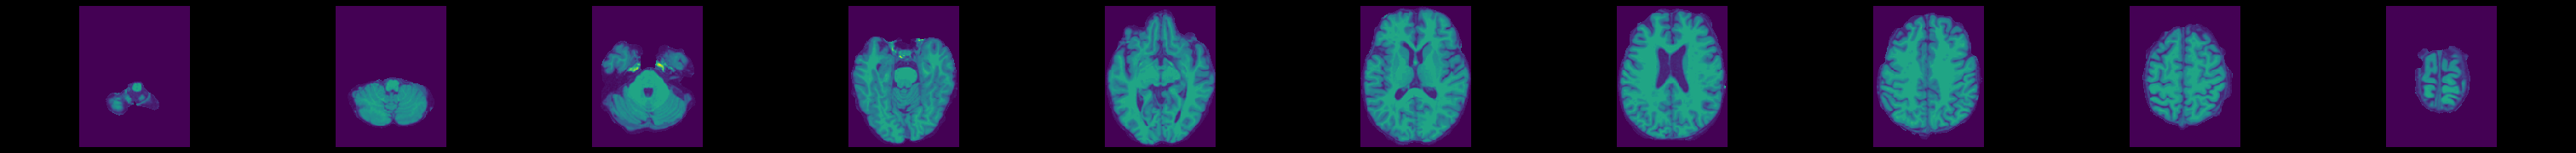

processed: ../../ADNI/002_S_0413/FreeSurfer_Cross-Sectional_Processing_brainmask/2007-06-01_07_04_09.0/S32938/mri/brainmask.mgz


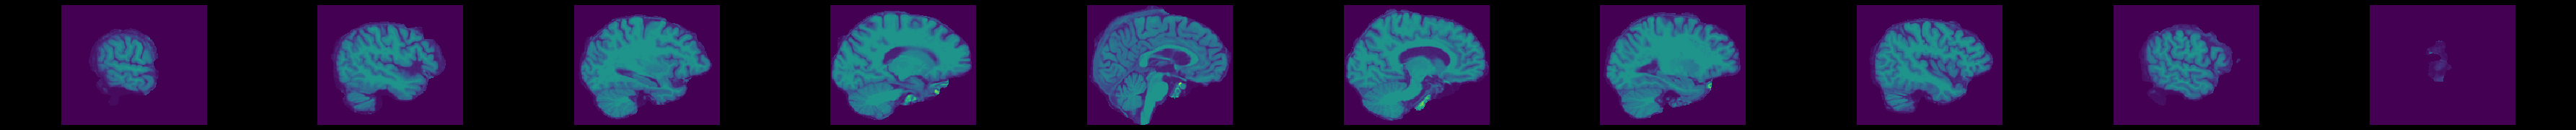

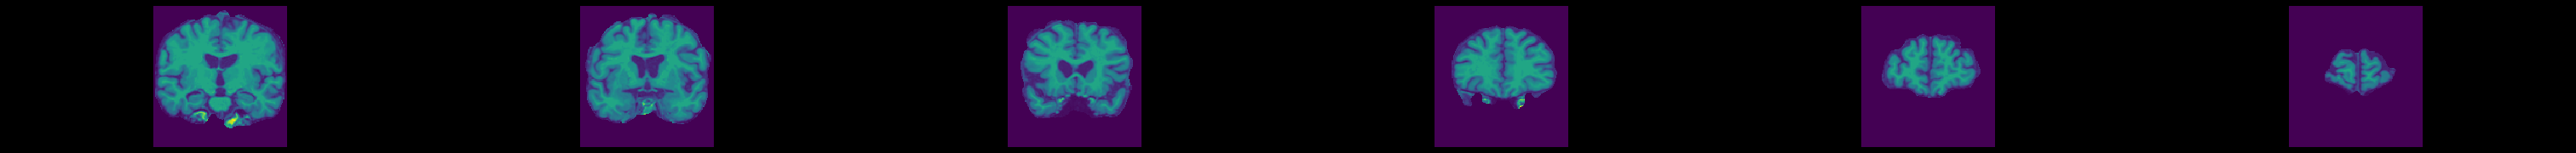

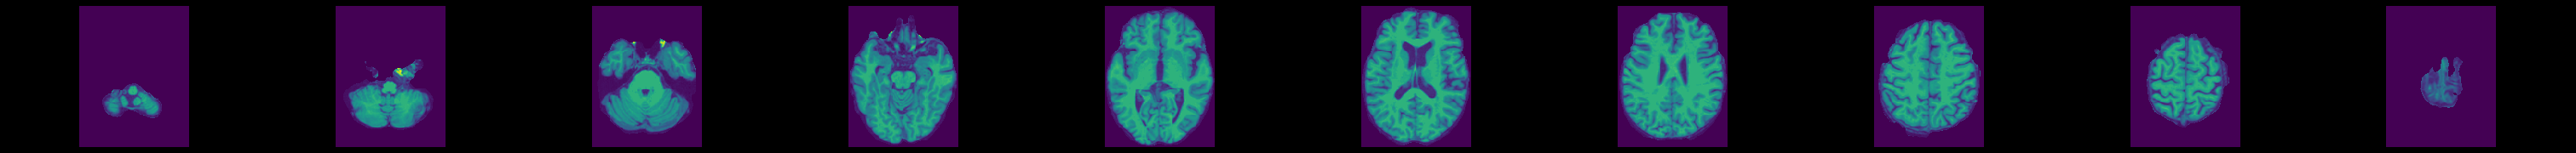

processed: ../../ADNI/002_S_0413/FreeSurfer_Cross-Sectional_Processing_brainmask/2008-07-31_14_39_56.0/S54591/mri/brainmask.mgz


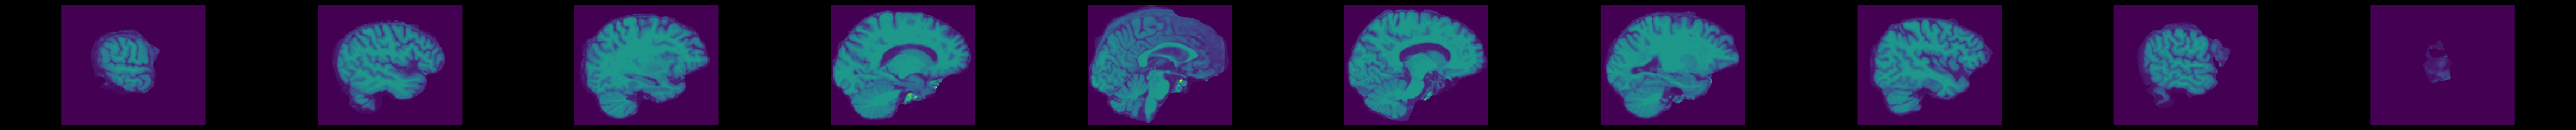

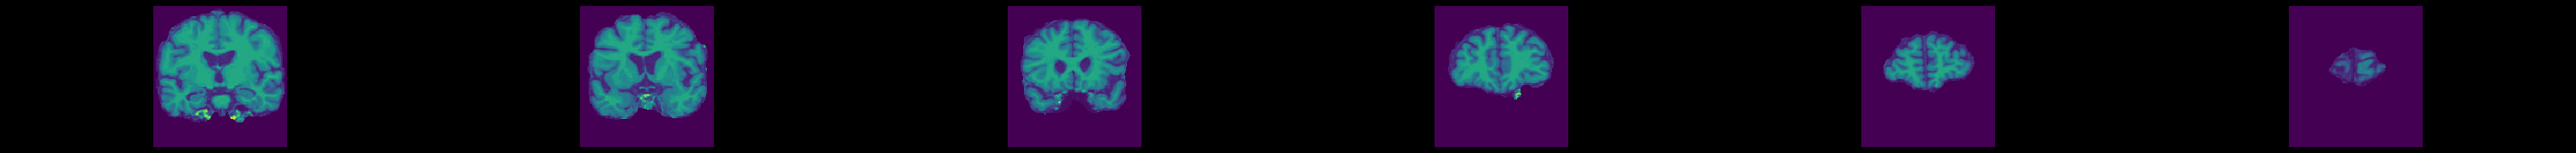

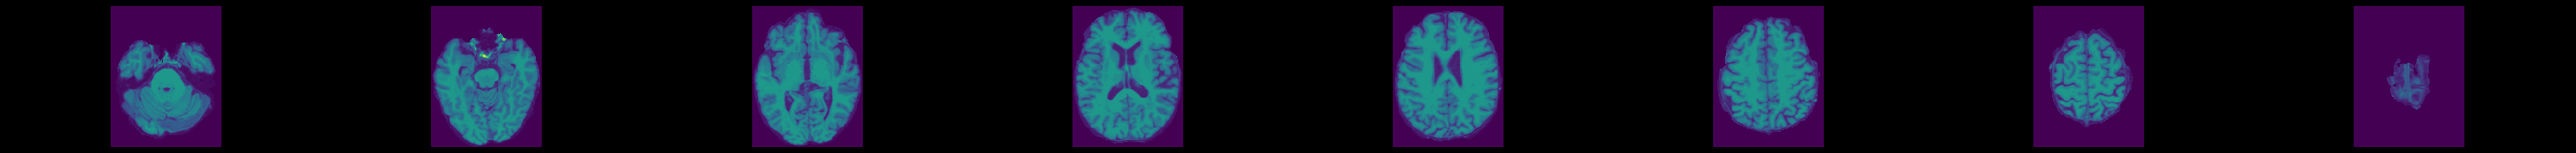

processed: ../../ADNI/002_S_0413/FreeSurfer_Cross-Sectional_Processing_brainmask/2009-05-04_14_34_42.0/S67062/mri/brainmask.mgz


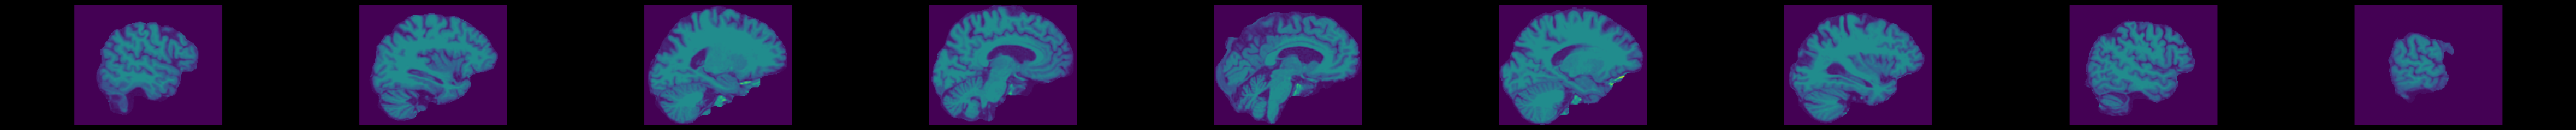

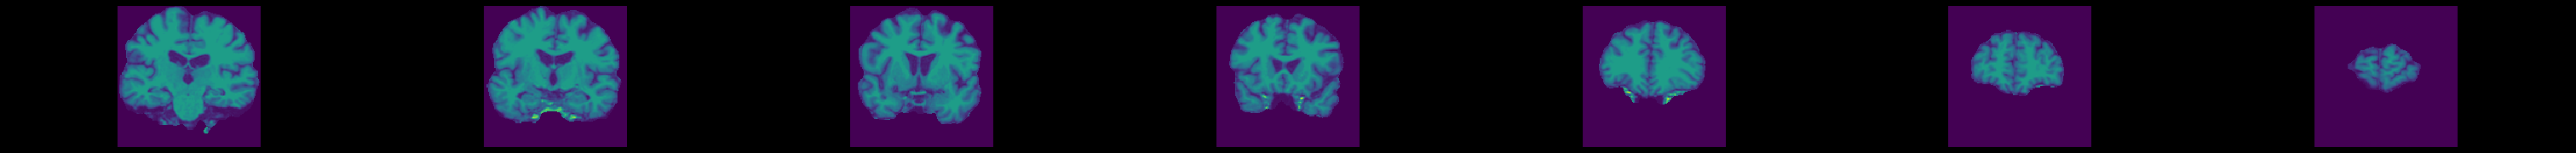

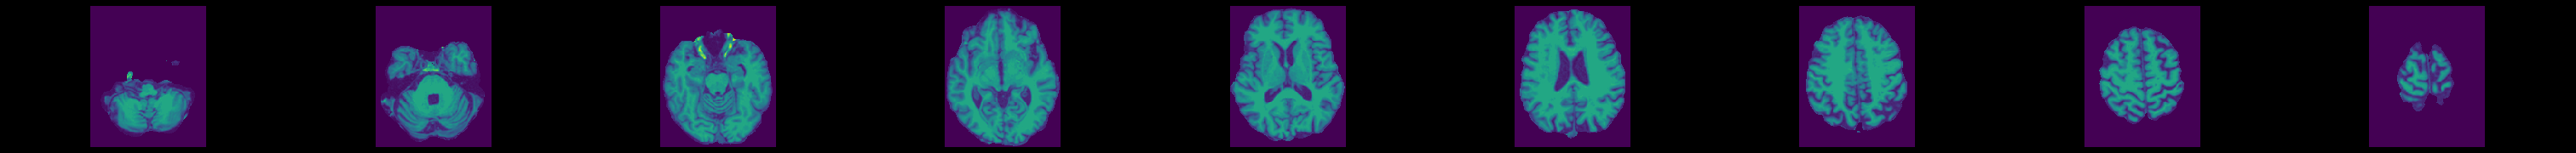

processed: ../../ADNI/002_S_0559/FreeSurfer_Cross-Sectional_Processing_brainmask/2006-05-23_15_31_00.0/S14875/mri/brainmask.mgz


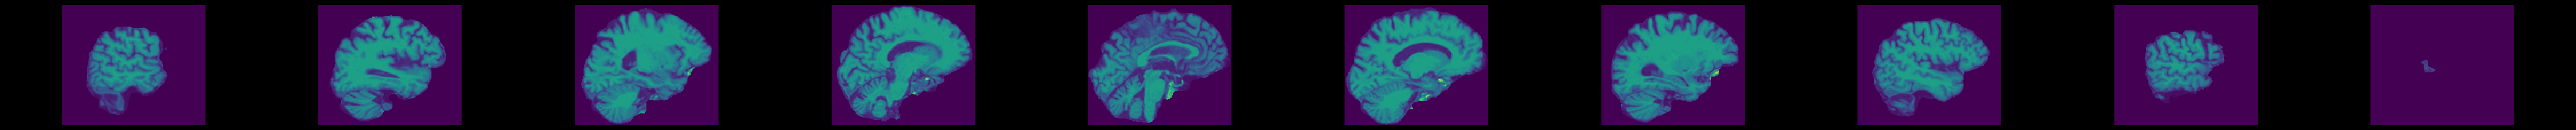

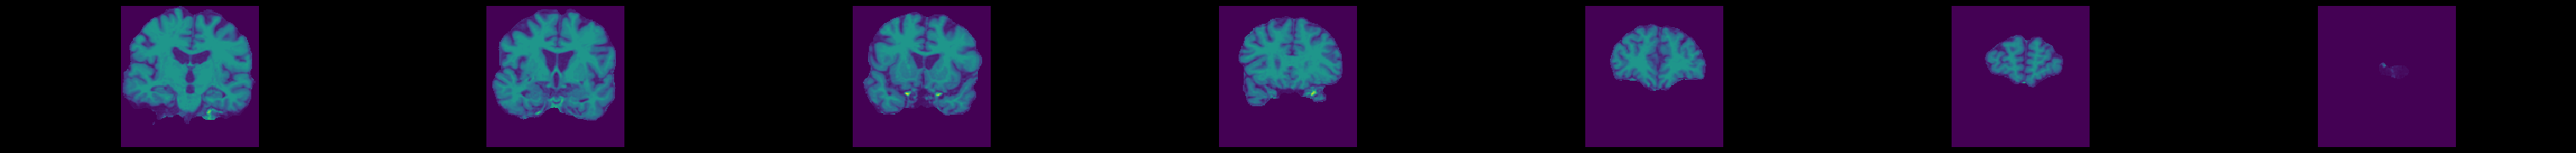

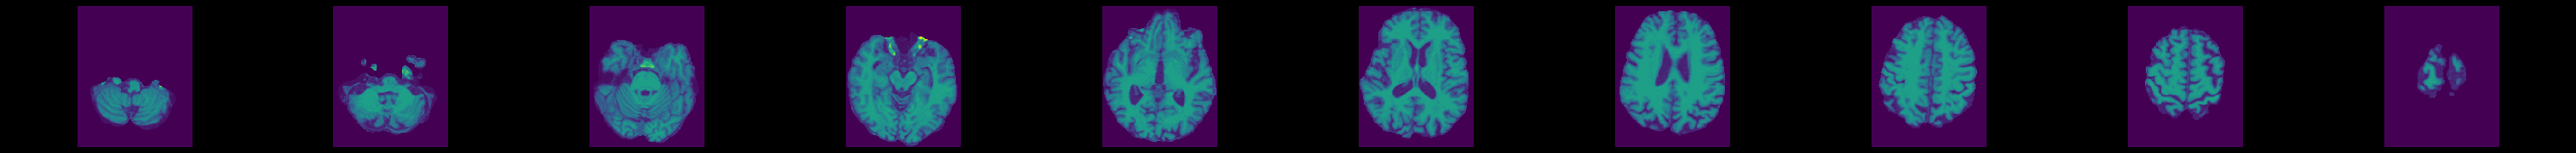

processed: ../../ADNI/002_S_0559/FreeSurfer_Cross-Sectional_Processing_brainmask/2008-08-15_18_09_30.0/S55641/mri/brainmask.mgz


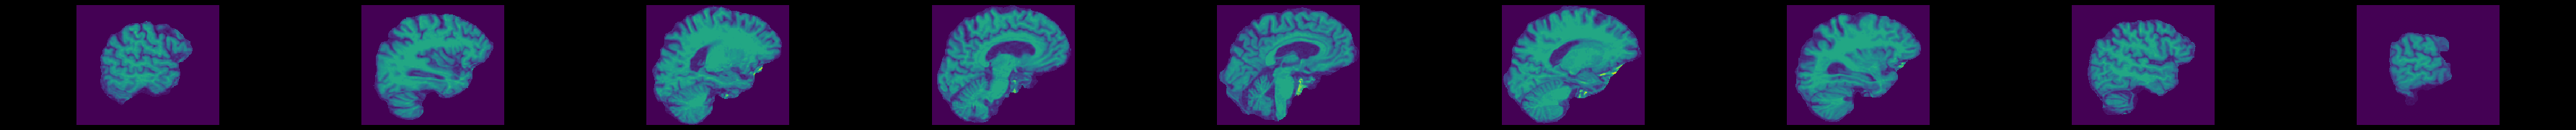

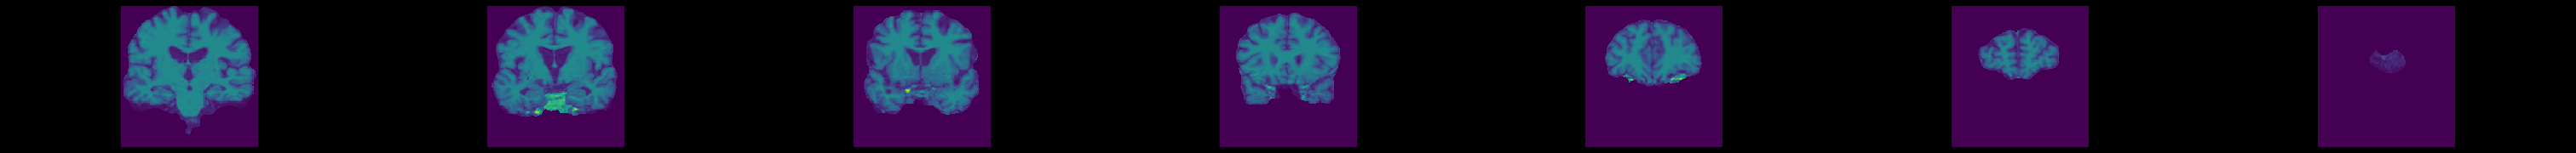

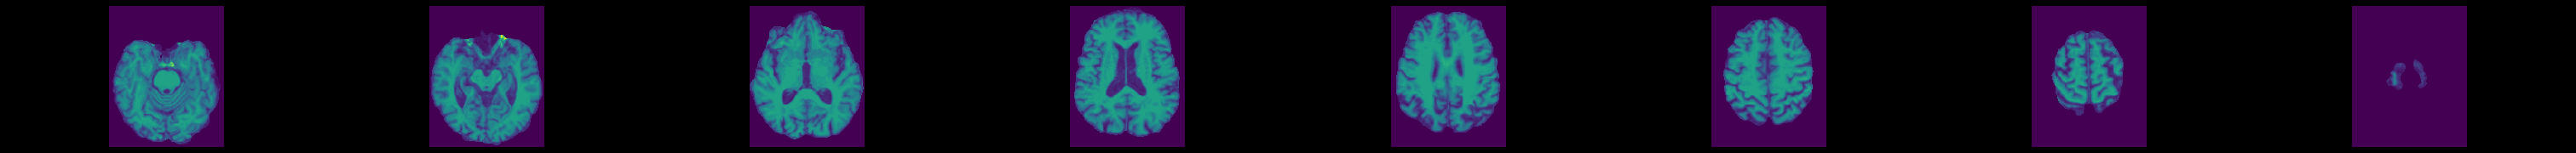

processed: ../../ADNI/002_S_0559/FreeSurfer_Cross-Sectional_Processing_brainmask/2009-06-30_17_19_02.0/S69298/mri/brainmask.mgz


KeyboardInterrupt: 

In [6]:
import argparse as argp
import nibabel as nib
import numpy as np
import os
import csv
from nilearn import plotting

padding = 0
count = [0]
arr = range(0, 256, 14)

def dive(root):
    for f in os.listdir(root):
        path = rf'{root}/{f}'
        if f.endswith('.mgz'):
#             nii_path = convert(root, f)
            clean_space(root, f)
            print(f'processed: {root}/image.nii')
        elif os.path.isdir(path):
            dive(path)
            if os.path.exists(rf'{root}/clipped.csv'):
                if f in converted_dirs:
                    continue
                # write to csv
                with open(rf'{root}/clipped.csv', 'a+', newline='') as csvfile:
                    fwriter = csv.writer(csvfile)
                    fwriter.writerow([f])
                    print([f])
            
def convert(root, f):
    os.system(rf'mri_convert {root}/{f} {root}/image.nii')
    count[0] += 1
    print(rf'count: {count[0]}')
    return rf'{root}/image.nii'

# clean the 0-intensity space surrounding the brain
def clean_space(root, f):
    mgz_path = rf'{root}/{f}'
    nii_path = rf'{root}/image.nii'
    
    img = nib.load(mgz_path)
    np_img = np.array(img.get_fdata())
    
    # clean X 
    x_len, y_len, z_len = len(np_img), len(np_img[0]), len(np_img[0, 0])
    zero_mask = np.zeros((y_len, z_len)) 
    del_inds = []
    for i in range(x_len):
        if np.sum(np_img[i] != zero_mask) == 0:
            del_inds.append(i)
    np_img = np.delete(np_img, del_inds, 0)
    # add paddings
    np_img = np.insert(np_img, [0 for i in range(padding)], zero_mask, 0)
    np_img = np.insert(np_img, [len(np_img) for i in range(padding)], zero_mask, 0)

    # clean Y
    x_len, y_len, z_len = len(np_img), len(np_img[0]), len(np_img[0, 0])
    zero_mask = np.zeros((x_len, z_len)) 
    del_inds = []
    for i in range(y_len):
        if np.sum(np_img[:, i] != zero_mask) == 0:
            del_inds.append(i)
    np_img = np.delete(np.swapaxes(np_img, 0, 1), del_inds, 0)
    np_img = np.swapaxes(np_img, 0, 1)
    # add paddings
    np_img = np.insert(np_img, [0 for i in range(padding)], np.zeros(z_len), 1)
    np_img = np.insert(np_img, [len(np_img[0]) for i in range(padding)], np.zeros(z_len), 1)

    # clean Z
    x_len, y_len, z_len = len(np_img), len(np_img[0]), len(np_img[0, 0])
    zero_mask = np.zeros((x_len, y_len)) 
    del_inds = []
    for i in range(z_len):
        if np.sum(np_img[:, :, i] != zero_mask) == 0:
            del_inds.append(i)
    np_img = np.delete(np.swapaxes(np_img, 0, 2), del_inds, 0)
    np_img = np.swapaxes(np_img, 0, 2)
    # add paddings
    np_img = np.insert(np_img, [0 for i in range(padding)], 0, 2)
    np_img = np.insert(np_img, [len(np_img[0][0]) for i in range(padding)], 0, 2)

    # write to disk
    feat = nib.Nifti1Image(np_img, img.affine)
    nib.save(feat, nii_path)
    
    #show image
    img = nib.load(nii_path)
    plotting.plot_img(img,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.plot_img(img,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='y')
    plotting.plot_img(img,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='z')
    plotting.show()
    
    

# In[20]:
converted_dirs = set()

if __name__ == '__main__':
#     parser = argp.ArgumentParser(description='convert .mgz files to .nii')
#     parser.add_argument('path', type=str, nargs=1)
#     args = parser.parse_args()
    if os.path.exists('../../ADNI/clipped.csv'):
        with open('../../ADNI/clipped.csv', 'r+') as csvfile:
            freader = csv.reader(csvfile)
            for row in freader:
                converted_dirs |= set(row)
        print('dirs:', converted_dirs)
    dive('../../ADNI')
